In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np

In [2]:
(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised = True,
    # Also return the `info` structure. 
    with_info = True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteD6GZRC/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteD6GZRC/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteD6GZRC/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [3]:
encoder = info.features['text'].encoder

In [4]:
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [5]:
for train_example, train_label in train_data.take(1):
  print('Encoded text:', train_example[:10].numpy())
  print('Label:', train_label.numpy())

Encoded text: [  62   18   41  604  927   65    3  644 7968   21]
Label: 0


In [6]:
BUFFER_SIZE = 1000

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32))

test_batches = (
    test_data
    .padded_batch(32))

In [7]:
model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
history = model.fit(train_batches,
                    epochs = 10,
                    validation_data = test_batches,
                    validation_steps = 30)

Epoch 1/10
782/782 [==============================] - 7s 9ms/step - loss: 0.6814 - accuracy: 0.5008 - val_loss: 0.6628 - val_accuracy: 0.5052
Epoch 2/10
782/782 [==============================] - 7s 8ms/step - loss: 0.6183 - accuracy: 0.5544 - val_loss: 0.5933 - val_accuracy: 0.6115
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.5383 - accuracy: 0.6679 - val_loss: 0.5316 - val_accuracy: 0.7479
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.4709 - accuracy: 0.7568 - val_loss: 0.4803 - val_accuracy: 0.7437
Epoch 5/10
782/782 [==============================] - 7s 8ms/step - loss: 0.4199 - accuracy: 0.8050 - val_loss: 0.4454 - val_accuracy: 0.7604
Epoch 6/10
782/782 [==============================] - 7s 8ms/step - loss: 0.3787 - accuracy: 0.8347 - val_loss: 0.4171 - val_accuracy: 0.7927
Epoch 7/10
782/782 [==============================] - 7s 9ms/step - loss: 0.3475 - accuracy: 0.8536 - val_loss: 0.3948 - val_accuracy: 0.8438
Epoch 

In [10]:
loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 3s 4ms/step - loss: 0.3316 - accuracy: 0.8558
Loss:  0.33164721727371216
Accuracy:  0.8558400273323059


In [11]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [12]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
  print("Prediction Score: ", predictions)
  output = ""
  if predictions[0][0] >= 0.5: output = "POSITIVE"
  elif predictions[0][0] <= -1: output = "NEGATIVE"
  else: output = "NEUTRAL"

  return output

In [13]:
sample_pred_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[-18.626644]]
NEGATIVE


In [14]:
sample_pred_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[6.219588]]
POSITIVE


In [15]:
sample_pred_text = ('This movie is awesome. The acting was incredicable. Highly recommend')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[14.431341]]
POSITIVE


In [16]:
sample_pred_text = ('This movie was so so. The acting was medicore. Kind of recommend')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[-20.629107]]
NEGATIVE


In [17]:
# AVENGERS: ENDGAME 5 STAR COMMENT

sample_pred_text = ("""I loved the movie a lot as I am great fan of marvel! Avengers: Endgame, which marks the end of the Infinity Saga, is spellbounding 
and surely an enthralling experience. The last film of the 'Avengers' franchise is remarkable and doesn't disappoint. Watching all our favourite superheroes 
in one film is just surpassing. Marvel has been working on this grand culmination ever since they released 'Iron Man'. I'm damn sure that all of their hard 
work and ambition has paid off. The directors, Anthony and Joe Russo, have made sure that it delivers an unforgettable experience. Christopher Markus and 
Stephen McFeely have come up with a screenplay full of epic and unpredictable moments. The film has a great balance of humour, emotions and action. 
The biggest strength of the film is the emotions. This is the most emotional superhero film I have ever seen. It's just perfect. The action sequences 
were jaw-dropping. The climatic battle left me amazed. It's just filled with memorable moments and cannot be described with words. The visuals are gorgeous 
and have a great impact on the film. The humour doesn't look exaggerated and manages to entertain throughout the film. The plot twists were very impressive 
and suspenseful. The film features many cameos of characters from the previous MCU films, which just gives a double dose of excitement. The background score 
gives me goosebumps, though I've listened to it several times. It was really clever to make changes to the characterization of the Hulk. I enjoyed that a lot. 
But the show-stealer is Robert Downey Jr, who plays the role of Tony Stark/Iron Man. The man who started it all proves yet again that there's no one else who 
can perfect his role. Do not miss his powerful moments in the final battle.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[14.509823]]
POSITIVE


In [18]:
# AVENGERS: ENDGAME 3 STAR COMMENT

sample_pred_text = ("""Overrated Sequel, But Still Good, But Violent! Beloved characters die, a character gets their head cut off, someone falls off a cliff, 
stabbings, punching, shooting, and more. The characters swear a bit. Even Captain America does! Role models include, Captain America, Iron Man, Hulk, AntMan, 
Black Widow, Hawkeye. Thor not so much because he SPOILER ALERT: got fat and played Fortnite the entire 5 year period. He was funny, but you may not want your 
kid wanting to say 'I want to be like the God of Thunder and play fortnite all day'. Characters did kiss. Thor drank a lot of beer. Captain America proved 
himself of something but not saying what. With reviewing the movie, the first half hour was good, then the next half hour was slow. The second half hour was 
pretty good, but the last hour was epic. From just starting out with Iron Man, Cap, Thor, and Hulk, to this amazing fight scene at the end, Avengers Endgame 
really pulled it off. Overall, pretty good for families and a good finale for the Infinity Saga.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[-7.1098347]]
NEGATIVE


In [19]:
# AVENGERS: ENDGAME 1 STAR COMMENT

sample_pred_text = ("""Disappointing storyline - too many sad crying scenes - too much shit swearing compared to other great Marvel movies! Even as 
an adult I don't appreciate swearing in movies. There are MANY people who don't use cuss words in their lives except maybe in adrenaline traffic moments. 
To hear Robert Downey jr's 'moment' with his young child using and laughing at the fact that she uses 'adult' language is teaching the new impressionable 
ages watching this, that it is okay when it isn't. They seemed to want to use their cuss word quota for the rating for this movie. Sad writing when that's 
how they get their best laughs from audience. Bring back your creative, quirky writers from the two The Defenders of the Galaxy. Now that's smart character 
development and writing without resorting to desperate shock value. We have loved every movie of that series and eagerly await the next one. The Storyline 
was soooo boring in this. All of us watching kept hoping it would improve and it didn't. I think the only real laugh we had was the encounter on the ship 
between Quill (StarLord) and Thor. Subtle, but funny. We all could've cared less if anyone died. That's how checked out we were watching this LONG 3 HRS!!! 
Why! It was torture and I felt robbed of my time in the end.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[-2.803657]]
NEGATIVE


In [20]:
sample_pred_text = ("""Superhero comics, and much of their adaptations, have long taken an outsized, soap opera-like approach to storytelling. 
At their best, they can take these fantastical ideas and make them emotionally resonant, even if there’s obviously no real-world phenomenon to connect them to. 
In some respects, Endgame pulls this off beautifully, like how the character Nebula confronts her past self through time travel, giving physical form to 
her personal growth. But as fun as the movie is, there’s an undeniable hollowness at its core induced by its unwillingness to follow through on certain 
ideas and symbols.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[0.6572151]]
POSITIVE


In [21]:
# AUGUST to JUNE: Bringing Life to School (http://augusttojune.com/press-media/audience-comments/)

sample_pred_text = ("""The film's ever-present focus on the 'big picture' of education and life! was much appreciated here and provided lots of talking points. 
In particular, we really liked seeing how you conferenced with parents, e.g., paraphrased:  'In a few more years, none of you will even remember who the early 
readers and late readers were', the overall approach to literacy- holistically focused rather than merely skills-focused, the ample time you provided to social 
growth/experiences/conflict resolution, and the fact that you did not choose to hide those moments where you, as a teacher, needed to separate or redirect 
children when disruptive.  There is a whole, whole, whole lot more that I wish to say! It is sad to know that this marked your retirement, but very 
heart-warming to know that your school carries on.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[7.7420597]]
POSITIVE


In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

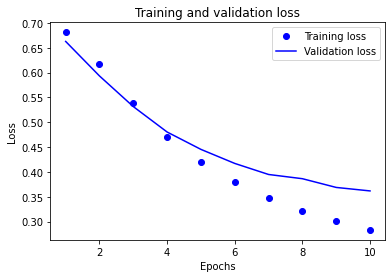

In [23]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

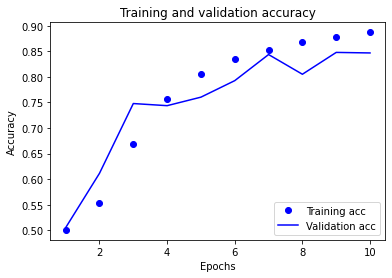

In [24]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()